In [21]:
import numpy as np
import data_helpers as dh

import matplotlib.pyplot as plt
import os

import tensorflow as tf
import datetime as dt


X,Y,files = dh.load_dataset('shared/Digits_1f1',(32,32),1)

# Parameters
learning_rate = 0.001
batch_size = 64
training_iters =150 
display_step = 50

# Network Parameters
n_input = 32*32 
n_classes = 10 # 
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture, treat img as matrix, so nr_rows=height nr_columns=width
    _X = tf.reshape(_X, shape=[-1, 32, 32, 1])

    # Convolution Layer 3x3x32 first, layer with relu
    conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling), change input size by factor of 2 
    conv1 = max_pool(conv1, k=2)
    # Apply Dropout
    #conv1 = tf.nn.dropout(conv1, _dropout)
    
    # Convolution Layer, 3x3x64
    conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2, k=2)
    # Apply Dropout
    #conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]]) # Reshape conv2 output to fit dense layer input
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1'])) # Relu activation
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    #out = tf.nn.softmax(out)
    return out


alpha=0.1
init_wc1 = alpha
init_wc2 = alpha 
init_wd1 = alpha
init_out = alpha
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(init_wc1*tf.random_normal([3, 3, 1, 32])), # 3x3 conv, 1 input, 32 outputs
    'wc2': tf.Variable(init_wc2*tf.random_normal([3, 3, 32, 64])), # 3x3 conv, 32 inputs, 64 outputs
    'wd1': tf.Variable(init_wd1*tf.random_normal([8*8*64, 1024])), # fully connected, 
    'out': tf.Variable(init_out*tf.random_normal([1024, n_classes])) # 1024 inputs, 2*10 output
}

biases = {
    'bc1': tf.Variable(0.1*tf.random_normal([32])),
    'bc2': tf.Variable(0.1*tf.random_normal([64])),
    'bd1': tf.Variable(0.1*tf.random_normal([1024])),
    'out': tf.Variable(0.1*tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)


# mnist version
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# ks version
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(pred,y)
#loss = tf.reduce_mean(cross_entropy)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


# minst version Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
######

# Initializing the variables
init = tf.global_variables_initializer()


losses = list()
accuracies = list()

saver = tf.train.Saver()
model_file = "./private/models/model_sigmoid_one_digit.ckpt"

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    if( os.path.isfile(model_file)): 
        saver.restore(sess, model_file)
    
    step = 0
    
    epoch=0
    start_epoch=dt.datetime.now()
    
    
    
    # Keep training until reach max iterations
    while step <= training_iters:
        batch_xs, batch_ys, idx = dh.random_batch(X, Y, batch_size)
        
        
        # Fit training using batch data
        start_op = dt.datetime.now()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        end_op = dt.datetime.now()
        
        if step % display_step == 0:
            
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            accuracies.append(acc)
            
            print("loss start {}".format(dt.datetime.now()))
            # Calculate batch loss
            batch_loss = sess.run(loss, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            losses.append(batch_loss)
            
            print("Iter " + str(step) +  ", Minibatch Loss= " + "{}".format(batch_loss) + ", Training Accuracy= " + "{}".format(acc))
            
            epoch+=1
        
        step += 1
        
        if step%5000==0:
            save_path = saver.save(sess, model_file)
        
        
    end_epoch = dt.datetime.now()
    print("Optimization Finished, end={} duration={}".format(end_epoch,end_epoch-start_epoch))
    
    
    test_size = min(400, X.shape[0])
    test_X = X[0:test_size,:]
    test_Y = Y[0:test_size,:]
    # Calculate accuracy 
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_X, y: test_Y, keep_prob: 1.}))
    




    
    

loss start 2017-12-05 18:57:30.733170
Iter 0, Minibatch Loss= 1125.174072265625, Training Accuracy= 0.21875
loss start 2017-12-05 18:57:35.887595
Iter 50, Minibatch Loss= 3.105586528778076, Training Accuracy= 0.859375
loss start 2017-12-05 18:57:40.749736
Iter 100, Minibatch Loss= 0.16737496852874756, Training Accuracy= 0.984375
loss start 2017-12-05 18:57:45.695709
Iter 150, Minibatch Loss= 0.05322530120611191, Training Accuracy= 0.984375
Optimization Finished, end=2017-12-05 18:57:45.724236 duration=0:00:15.267329
Testing Accuracy: 0.9975


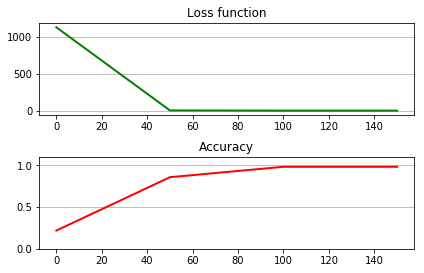

In [22]:
import matplotlib.pyplot as plt

iter_steps = [ display_step*k for k in range(int(training_iters/display_step)+1)]

trainning_version = 'plots/digits1f1_acc_init_{}.png'.format(alpha)

imh =plt.figure(1,figsize=(15,8),dpi=160)
#imh.tight_layout() 
#imh.subplots_adjust(top=0.88)


plt.subplot(211)
plt.grid(b=True, which='major', axis='y')
plt.plot(iter_steps,losses, '-g', label='Loss',linewidth=2.0)
#plt.semilogy(iter_steps,losses, '-g', label='Loss',linewidth=2.0)
plt.title('Loss function')
plt.subplot(212)
plt.ylim([0,1.1])
plt.grid(b=True, which='major', axis='y')
plt.plot(iter_steps,accuracies, '-r', label='Acc', linewidth=2.0)
plt.title('Accuracy')
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()
plt.savefig(trainning_version) 